# Introduction: Exploring Data and Defining Objectives

In [3]:

# Magic function that will make your plot outputs appear and be stored within the notebook
%matplotlib inline

# Function used to to render higher resolution images
%config InlineBackend.figure_format = 'retina'
%pip install pyarrow        ### pyarrow and fastparquet are new to me: these are necessary for loading parquet file data
%pip install fastparquet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import FuncAnimation





Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
datapath = '../../IceCube_Training_Data/'                                                   ### Adjust your path to match where you are keeping the parquet files
batch_list = [pd.read_parquet(datapath+'batch_'+str(i)+'.parquet') for i in range(1,6)]     ### I renamed the parquet files so I could easily loop over them and aggregate the events
rawdata = pd.concat(batch_list)
events = rawdata.index.drop_duplicates()

print(rawdata.head())




          sensor_id  time  charge  auxiliary
event_id                                    
24             3918  5928   1.325       True
24             4157  6115   1.175       True
24             3520  6492   0.925       True
24             5041  6665   0.225       True
24             2948  8054   1.575       True


In [6]:
rawdata_meta = pd.read_parquet('../../train_meta.parquet')
rawdata_meta = rawdata_meta.loc[rawdata_meta['event_id'].isin(events)]
sensor_geometry = pd.read_csv('../../sensor_geometry.csv').set_index('sensor_id')
print(rawdata_meta.head())


   batch_id  event_id  first_pulse_index  last_pulse_index   azimuth    zenith
0         1        24                  0                60  5.029555  2.087498
1         1        41                 61               111  0.417742  1.549686
2         1        59                112               147  1.160466  2.401942
3         1        67                148               289  5.845952  0.759054
4         1        72                290               351  0.653719  0.939117


In [12]:
def event_reconstruction(event_id, event_meta_df, sensor_data_df, sensor_geometry_df, auxiliary=False):
    
    event_meta = event_meta_df.loc[event_meta_df['event_id'] == event_id]
    azimuth = event_meta['azimuth'].values[0]
    zenith = event_meta['zenith'].values[0]
    print('azimuth: '+str(azimuth))

    # Filter sensor data for the given event_id
    event_sensors = sensor_data_df[sensor_data_df.index == event_id]
    
    x_all = sensor_geometry_df['x'].values
    y_all = sensor_geometry_df['y'].values
    z_all = sensor_geometry_df['z'].values

    # Get event sensor coordinates based on auxiliary option
    if auxiliary:

        auxiliary_sensor_ids = event_sensors[event_sensors['auxiliary'] == True]
        auxiliary_sensor_ids = auxiliary_sensor_ids.drop_duplicates(subset=['sensor_id'])    
        event_sensor_coordinates = sensor_geometry[sensor_geometry.index.isin(auxiliary_sensor_ids['sensor_id'])]
        charges = auxiliary_sensor_ids['charge'].values
        times = auxiliary_sensor_ids['time'].values


    else:
        event_sensors = event_sensors.drop_duplicates(subset=['sensor_id'])
        event_sensor_coordinates = sensor_geometry_df[sensor_geometry_df.index.isin(event_sensors['sensor_id'])]
        charges = event_sensors['charge'].values
        times = event_sensors['time'].values
        print('len charges: '+str(charges.shape))

    charge_min = np.min(charges)
    charge_max = np.max(charges)
    marker_sizes = 5 + (200 * ((charges - charge_min) / (charge_max - charge_min)) ) # Adjust the range of marker sizes as needed

    time_min = np.min(times)
    plottimes = (times - time_min)/1000. # Adjust the range of marker sizes as needed


    print(event_sensor_coordinates['x'].shape, event_sensor_coordinates['y'].shape, event_sensor_coordinates['z'].shape,marker_sizes.shape)
    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_all, y_all, z_all, c='gray', marker='o', s = 1, alpha = .1)

    # Plot the triggered sensors with markers

    colormap = plt.cm.plasma
    plot = ax.scatter(event_sensor_coordinates['x'].values, event_sensor_coordinates['y'].values, event_sensor_coordinates['z'].values, marker='o', s=marker_sizes, c=plottimes, cmap=colormap)


    center_x = np.mean(event_sensor_coordinates['x'].values)
    center_y = np.mean(event_sensor_coordinates['y'].values)
    center_z = np.mean(event_sensor_coordinates['z'].values)

    direction = np.array([
        np.sin(zenith) * np.cos(azimuth),
        np.sin(zenith) * np.sin(azimuth),
        np.cos(zenith)
    ])

    center = np.array([center_x,center_y,center_z])
    arrow_length = 1600
    arrow_center = center - (arrow_length / 2) * direction
    arrow_end = center + (arrow_length / 2) * direction

    # Plot the arrow passing through the center point
    ax.quiver(arrow_center[0], arrow_center[1], arrow_center[2],
            direction[0], direction[1], direction[2], color='red',
            length=arrow_length,arrow_length_ratio=.1)


    cax = fig.add_axes([0.25, 0.87, 0.53, 0.03])  # Adjust the position and size as needed
    cbar = fig.colorbar(plot, cax=cax, orientation='horizontal')
    cax.text(5.5, 1.75, r'Time [$ \mu $s]', ha='center', va='center')

    # cbar = fig.colorbar(plot, ax=ax,shrink=.7)

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim(-600,600)
    ax.set_ylim(-600,600)
    ax.set_zlim(-600,600)
    ax.set_title(f'Neutrino Event {event_id}, Aux = {auxiliary}',loc="center", y=1.18)
    ax.grid(False)

    # fig.show()
    # Show the plot
    plt.show()


def event_reconstruction_gif(event_id, event_meta_df, sensor_data_df, sensor_geometry_df, auxiliary=False):
       
    event_meta = event_meta_df.loc[event_meta_df['event_id'] == event_id]
    azimuth = event_meta['azimuth'].values[0]
    zenith = event_meta['zenith'].values[0]
    print('azimuth: '+str(azimuth))

    # Filter sensor data for the given event_id
    event_sensors = sensor_data_df[sensor_data_df.index == event_id]
    
    x_all = sensor_geometry_df['x'].values
    y_all = sensor_geometry_df['y'].values
    z_all = sensor_geometry_df['z'].values

    # Get event sensor coordinates based on auxiliary option
    if auxiliary:

        auxiliary_sensor_ids = event_sensors[event_sensors['auxiliary'] == True]
        auxiliary_sensor_ids = auxiliary_sensor_ids.drop_duplicates(subset=['sensor_id'])    
        event_sensor_coordinates = sensor_geometry[sensor_geometry.index.isin(auxiliary_sensor_ids['sensor_id'])]
        charges = auxiliary_sensor_ids['charge'].values
        times = auxiliary_sensor_ids['time'].values


    else:
        event_sensors = event_sensors.drop_duplicates(subset=['sensor_id'])
        event_sensor_coordinates = sensor_geometry_df[sensor_geometry_df.index.isin(event_sensors['sensor_id'])]
        charges = event_sensors['charge'].values
        times = event_sensors['time'].values
        print('len charges: '+str(charges.shape))

    charge_min = np.min(charges)
    charge_max = np.max(charges)
    marker_sizes = 5 + (200 * ((charges - charge_min) / (charge_max - charge_min)) ) # Adjust the range of marker sizes as needed

    time_min = np.min(times)
    plottimes = (times - time_min)/1000. # Adjust the range of marker sizes as needed


    print(event_sensor_coordinates['x'].shape, event_sensor_coordinates['y'].shape, event_sensor_coordinates['z'].shape,marker_sizes.shape)
    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_all, y_all, z_all, c='gray', marker='o', s = 1, alpha = .1)

    # Plot the triggered sensors with markers

    colormap = plt.cm.plasma
    plot = ax.scatter(event_sensor_coordinates['x'].values, event_sensor_coordinates['y'].values, event_sensor_coordinates['z'].values, marker='o', s=marker_sizes, c=plottimes, cmap=colormap)


    center_x = np.mean(event_sensor_coordinates['x'].values)
    center_y = np.mean(event_sensor_coordinates['y'].values)
    center_z = np.mean(event_sensor_coordinates['z'].values)

    direction = np.array([
        np.sin(zenith) * np.cos(azimuth),
        np.sin(zenith) * np.sin(azimuth),
        np.cos(zenith)
    ])

    center = np.array([center_x,center_y,center_z])
    arrow_length = 1600
    arrow_center = center - (arrow_length / 2) * direction
    arrow_end = center + (arrow_length / 2) * direction

    # Plot the arrow passing through the center point
    ax.quiver(arrow_center[0], arrow_center[1], arrow_center[2],
            direction[0], direction[1], direction[2], color='red',
            length=arrow_length,arrow_length_ratio=.1)


    cax = fig.add_axes([0.25, 0.87, 0.53, 0.03])  # Adjust the position and size as needed
    cbar = fig.colorbar(plot, cax=cax, orientation='horizontal')
    cax.text(5.5, 1.75, r'Time [$ \mu $s]', ha='center', va='center')

    # cbar = fig.colorbar(plot, ax=ax,shrink=.7)

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim(-600,600)
    ax.set_ylim(-600,600)
    ax.set_zlim(-600,600)
    ax.set_title(f'Neutrino Event {event_id}, Aux = {auxiliary}',loc="center", y=1.18)
    ax.grid(False)


    def rotate(angle):
        ax.view_init(azim=angle)


    rot_animation = FuncAnimation(fig, rotate, frames=np.arange(0,362,1),interval=40)
    rot_animation.save(f'Graphics/{event_id}_rotation.gif', dpi=300, writer='imagemagick')



    # fig.show()
    # Show the plot





azimuth: 0.6537188048693313


MovieWriter imagemagick unavailable; using Pillow instead.


(35,) (35,) (35,) (35,)


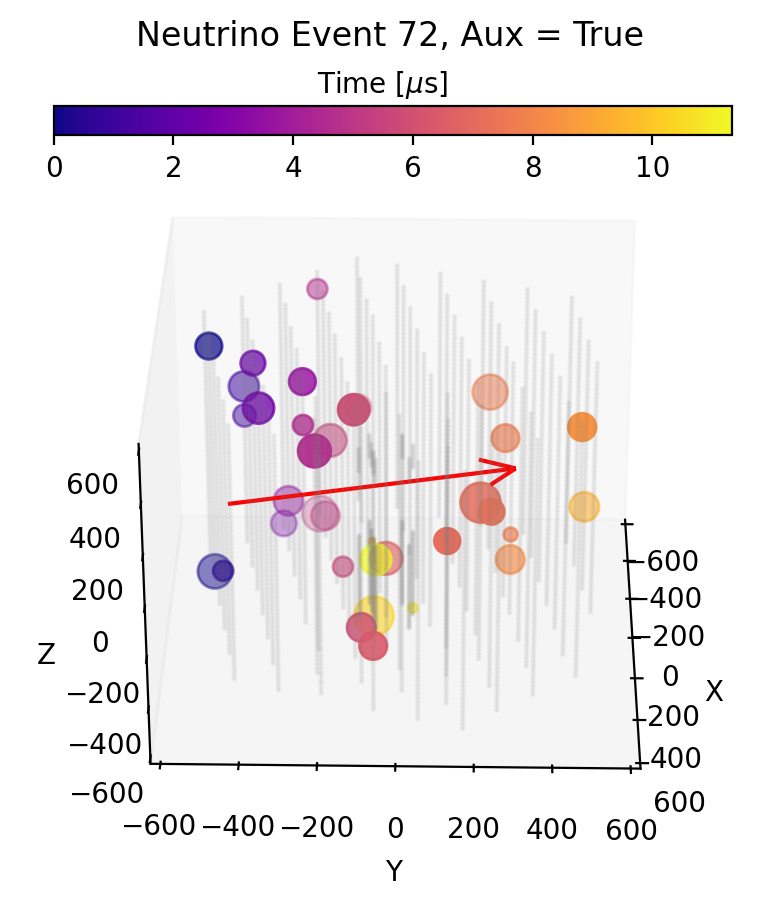

In [13]:


event_reconstruction_gif(72, rawdata_meta, rawdata, sensor_geometry, auxiliary=True)





azimuth: 0.6537188048693313
len charges: (48,)
(48,) (48,) (48,) (48,)


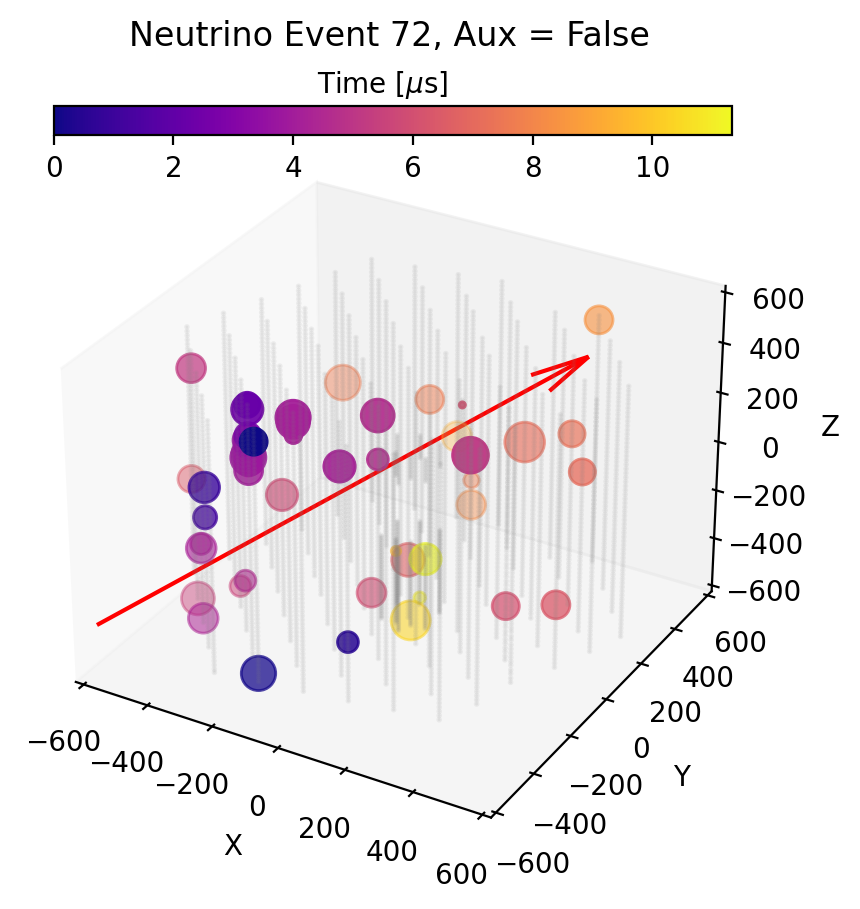

In [9]:
event_reconstruction(72, rawdata_meta, rawdata, sensor_geometry, auxiliary=False)

In [8]:
rawdata_meta['event_id'].values

<IntegerArray>
[       24,        41,        59,        67,        72,        77,        79,
        82,       121,       127,
 ...
 331932694, 331932700, 331932728, 331932770, 331932779, 331932801, 331932836,
 331932852, 331932854, 331932899]
Length: 1000000, dtype: Int64